In [6]:
%matplotlib inline
import glob 
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
# Install this using: 
# conda install -c conda-forge scanpy --yes
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Demultiplex cells and molecules:
demux.py --use CS2C8U6 *.fastq.gz --y

## Map with star  (Per library)
STAR 
--runThreadN 8 
--readFilesCommand zcat 
--outSAMtype BAM SortedByCoordinate 
--outMultimapperOrder Random 
--outFilterMultimapNmax 1000 
--genomeDir /hpc/hub_oudenaarden/bdebarbanson/data/jens/snake/transcriptome-assembly_STAR75
--readFilesIn demultiplexedR1_val_1.fq.gz demultiplexedR2_val_2.fq.gz 
--outFileNamePrefix STAR_mapped --genomeChrBinNbits 12

## Assign reads to molecules  (Per library)
Gene assignment by mapping to transcriptome

Molecule assingment:

universalBamTagger.py STAR_mappedAligned.sortedByCoord.out.bam --ftag -tag chrom
## Count molecules per gene per cell  (Per library)
taggedBamFileToCountTable.py -featureTags chrom -sampleTags SM --divideMultimapping --dedup ./tagged/STAR_mappedAligned.sortedByCoord.out.bam -o ${lib}COUNTS.pickle.gz

In [7]:

fileList = [
 '../recount/HUB-YP-005_HC3G3BGX9_S4COUNTS.pickle.gz',
 '../recount/HUB-YP-006_HC3G3BGX9_S5COUNTS.pickle.gz',
 '../recount/HUB-YP-007_HHCJCBGX9_S4COUNTS.pickle.gz',
 '../recount/HUB-YP-008_HHCJCBGX9_S5COUNTS.pickle.gz'
]

In [8]:
dfs = [pd.read_pickle(x) for x in fileList]

In [9]:
df = pd.concat(dfs,axis=1,sort=True).fillna(0).T

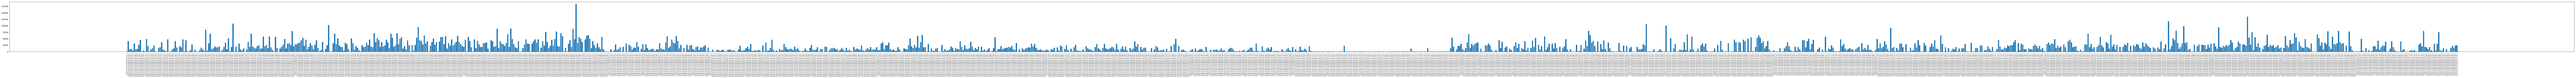

In [10]:
def barPlot(sums):
    fig, ax = plt.subplots(figsize=(250,5))
    ax.bar(range(len(sums)),sums)
    ax.set_xticks(range(len(sums)) )
    ax.set_xticklabels(sums.index, rotation=90)
    ax.xaxis.set_tick_params(labelsize=7)
barPlot(df.sum(1))

In [11]:
del dfs

In [12]:
tgIdToGene = {}
scaffoldToGeneId={}
with open('../../tgMapList.tsv') as f:
    for line in f:
        parts = line.strip().split(None,1)
        tgIdToGene[parts[0]] = parts[1]

with open('../../tgMap.tsv') as f:
    for line in f:
        parts = line.strip().split(None,1)
        scaffoldToGeneId[parts[0]] = parts[1]

longColnames = []
for index in df.columns:
    longColnames.append( tgIdToGene[scaffoldToGeneId[index]] )


In [13]:
# Dataset size before collapsing same annotation genes
print(df.shape)

(1536, 309896)


In [14]:
df.columns = longColnames
del longColnames

In [15]:
def barPlot(sums):
    fig, ax = plt.subplots(figsize=(150,5))
    ax.bar(range(len(sums)),sums)
    ax.set_xticks(range(len(sums)) )
    ax.set_xticklabels(sums.index, rotation=90)
    ax.xaxis.set_tick_params(labelsize=9)
#barPlot(df.sum())

In [16]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 1.4 on 2019-04-09 17:49.
Dependencies: anndata==0.6.17 numpy==1.15.4 scipy==1.0.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [17]:
summedCols = df.groupby(df.columns, axis=1).sum()

In [18]:
# Dataset size after collapsing same annotation genes
print(summedCols.shape)

(1536, 128423)


In [19]:
# Uploaded counts
libraries = set( [i.split('_')[0] for i in df.index.levels[0]])
k = np.array([i.split('_')[0] for i in df.index.levels[0]])
for library in libraries:
    print(library)
    summedCols[library==k].T.to_csv(f'./annotation_collapsed_counts_{library}.csv')


HUB-YP-007
HUB-YP-006
HUB-YP-008
HUB-YP-005


In [20]:
# removing genes with annotations we are not interested in
banned = [
 'rRNA','ribosomal','mitochondrial','mitochondrion','microsatellite','transposon','SINE','LINE repeat','noBlast'  
]
keptGenes = [geneName for geneName in summedCols.columns if not any( (b in geneName for b in banned) )]


In [21]:
len(keptGenes)

42803

In [22]:
adata = sc.AnnData(summedCols)
#adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 1536 × 128423 

In [23]:
del df

In [24]:
batches = [ob[0].split('_')[0].split('-')[-1] for ob in adata.obs_names]
adata.obs['batch'] = batches

In [25]:
minCount = 1000
sc.pp.filter_cells(adata, min_counts=minCount)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=2)

filtered out 348 cells that have less than 1000 counts
filtered out 3449 genes that are detected in less than 2 cells


In [26]:
keptGenes = [geneName for geneName in adata.var.index if not any( (b in geneName for b in banned) )]

In [27]:
len(keptGenes)

42507

In [28]:
adata = adata[:,keptGenes]

In [29]:
adata.shape

(1188, 42507)

In [30]:
# Transpose for RaceID analysis:
exportFrame = adata.to_df().transpose()

In [31]:

renamed = []
libraries = set()
for c in exportFrame.columns:
    library = c[0].split('_')[0].split('-')[-1]
    library = library.replace('033','028')
    libraries.add(library)
    cell = int(c[0].split('_')[-1])
    
    
    if library in ['028', '029']:
        quads = "D_pos","D_neg",'E_pos','E_neg'
    else:
        quads = "D_NA","D_NA",'E_NA','E_NA'
    quad = quads[ int( cell/(384/4)) ]
    
    
    
    renamed.append('_'.join((quad,library,str(cell))))

In [32]:
exportFrame.columns = renamed

In [33]:
exportFrame = exportFrame.sort_index(axis=1)

In [34]:
exportFrame.shape

(42507, 1188)

In [35]:
exportFrame.to_csv('./forRaceID.csv')